In [3]:
%load_ext autoreload
%autoreload 2

In [1]:
from pathlib import Path

import zarr
import random
import torch
import numpy as np
import matplotlib.pyplot as plt

# Check if CUDA is available and set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print("Device:", device)

Device: cuda


In [7]:
from src.models.encoders import models

**All Files Loading Info**


In [4]:
# NOTE: Change this to wherever the project is located in your google drive
project_root = Path(".").resolve().parent
# project_root = Path("/content/drive/MyDrive/17 – Research/sim-2-real-representation-learning") # Lars
data_path = project_root / "data" / "processed"
models_path = project_root / "models"
embeddings_path = project_root / "embeddings"

print("Project root:", project_root)
print("Data path:", data_path)
print("Models path:", models_path)
print("Embeddings path:", embeddings_path)

Project root: /home/ubuntu/semrep
Data path: /home/ubuntu/semrep/data/processed
Models path: /home/ubuntu/semrep/models
Embeddings path: /home/ubuntu/semrep/embeddings


In [5]:
# Load the data
sim2 = zarr.open(data_path / "one_leg_med_sim.zarr", mode="r")
real = zarr.open(data_path / "one_leg_low_real.zarr", mode="r")
sim2_imgs = sim2["color_image2"]
real_imgs = real["color_image2"]
sim2_labels = sim2["action/pos"]
real_labels = real["action/pos"]


print(f"Loaded {len(sim2['episode_ends'])} trajectories containing {sim2_imgs.shape[0]} frames")
print(f"Loaded {len(real['episode_ends'])} trajectories containing {real_imgs.shape[0]} frames")

Loaded 50 trajectories containing 24131 frames
Loaded 50 trajectories containing 27699 frames


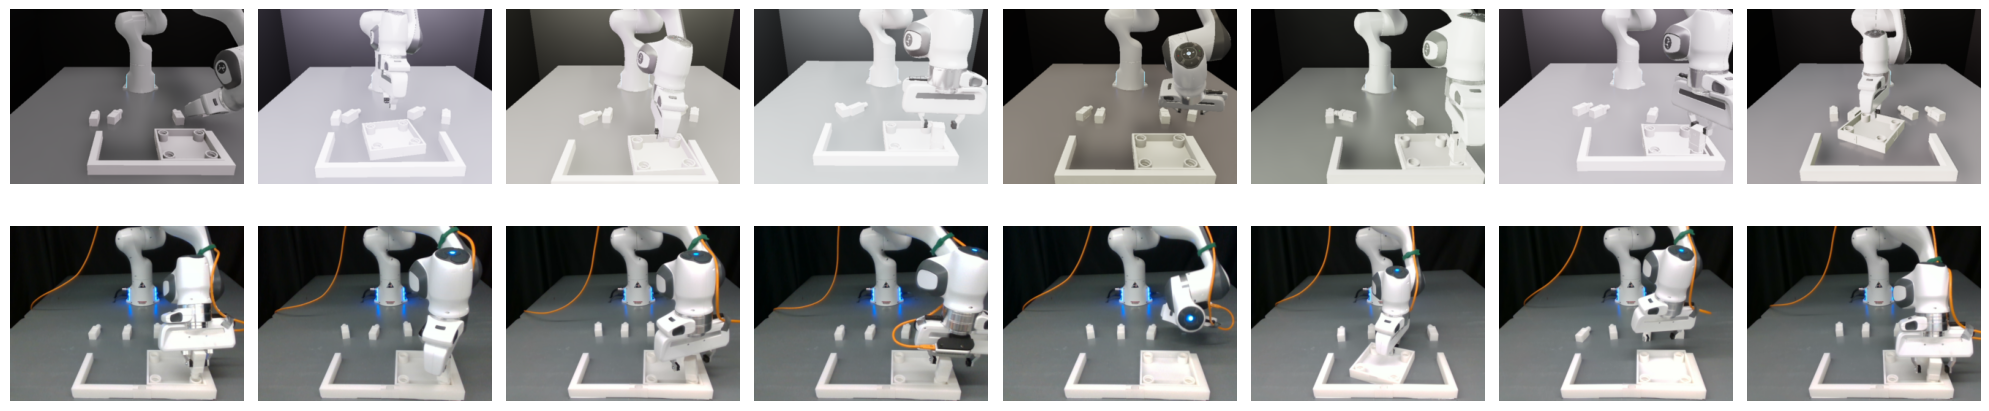

In [6]:
# Sample 8 images from each dataset
sim2_indices = np.random.choice(sim2_imgs.shape[0], size=8, replace=False)
real_indices = np.random.choice(real_imgs.shape[0], size=8, replace=False)

# Create a figure and axes
fig, axes = plt.subplots(2, 8, figsize=(20, 5))

for i, idx in enumerate(sim2_indices):
    axes[1 - 1, i].imshow(sim2_imgs[idx])
    axes[1 - 1, i].axis("off")

for i, idx in enumerate(real_indices):
    axes[2 - 1, i].imshow(real_imgs[idx])
    axes[2 - 1, i].axis("off")

plt.tight_layout()
plt.show()

**Load Models**


In [ ]:
# Choose the model to use
selected_model_name = ""  # Change this to the desired model's name

# Load the selected model
model = models[selected_model_name]().cuda()
model.eval()

/home/ubuntu/miniforge3/envs/sr/lib/python3.10/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
/home/ubuntu/miniforge3/envs/sr/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/ubuntu/miniforge3/envs/sr/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/home/ubuntu/miniforge3/envs/sr/lib/python3.10/site-packages/r3m/__init__.py:73: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly

R3M(
  (cs): CosineSimilarity()
  (bce): BCELoss()
  (sigm): Sigmoid()
  (convnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): B

### Example of loading our own custom weights

I've trained some models on the data that we've visualized above (the real and the nicely rendered sets). Here, I'll show an example of how we can load up our own weights, and I'd be really curious to see how these embeddings might be different to the pre-trained encoders.


**Output Dimensions**


In [9]:
def output():
    if selected_model_name == "MVP" or selected_model_name == "VIP":
        random_input = torch.rand((1, 3, 224, 224)).to(device)  # Move to the correct device
    else:
        random_input = (
            torch.randint(0, 255, size=(1, 3, 224, 224)).float().to(device) / 255.0
        )  # Convert to float and move to device

    # Pass the random data through the encoder
    with torch.no_grad():
        output = model(random_input)

    return output


model_output_dim = output()

**TSNE**


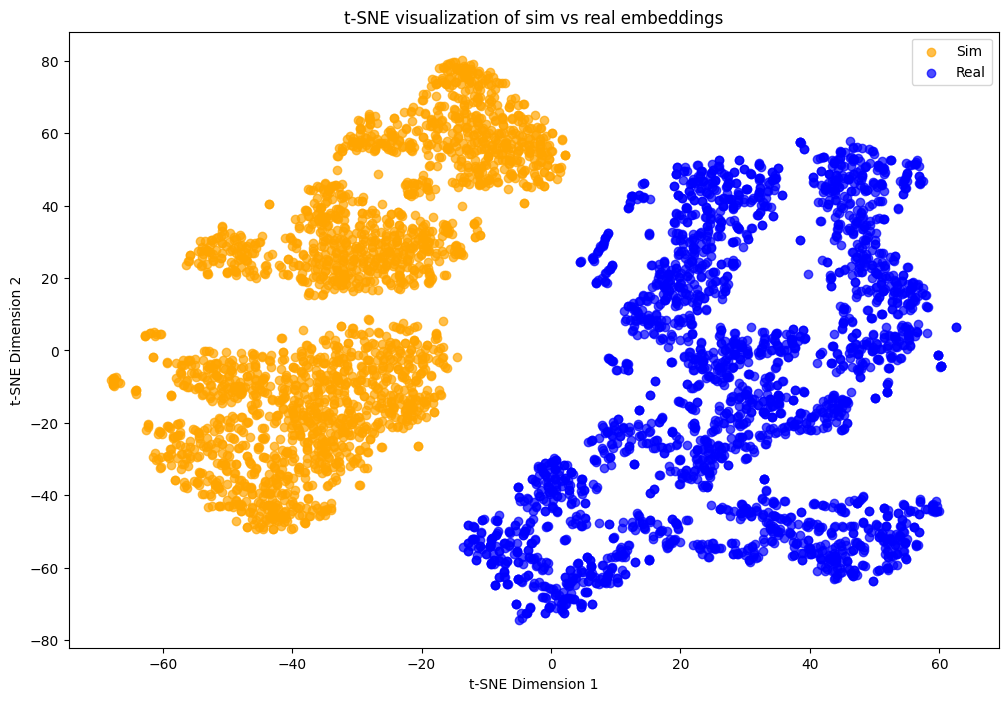

In [35]:
from src.models.tsne import plot_tsne

file_path = embeddings_path / "encoders/ViT.npz"

# Sample a subset of the data
n_samples = 5000
dataset = np.load(file_path)


indices = np.random.choice(len(dataset["embeddings"]), n_samples, replace=False)

embeddings = dataset["embeddings"][indices]
domain_labels = dataset["dataset_flag"][indices]

# Plot t-SNE
plot_tsne(embeddings, domain_labels)

**GradCAM for the CNNs**

/tmp/ipykernel_236784/823891431.py:40: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  raw_image_resized = np.array(raw_image_resized) / 255.0


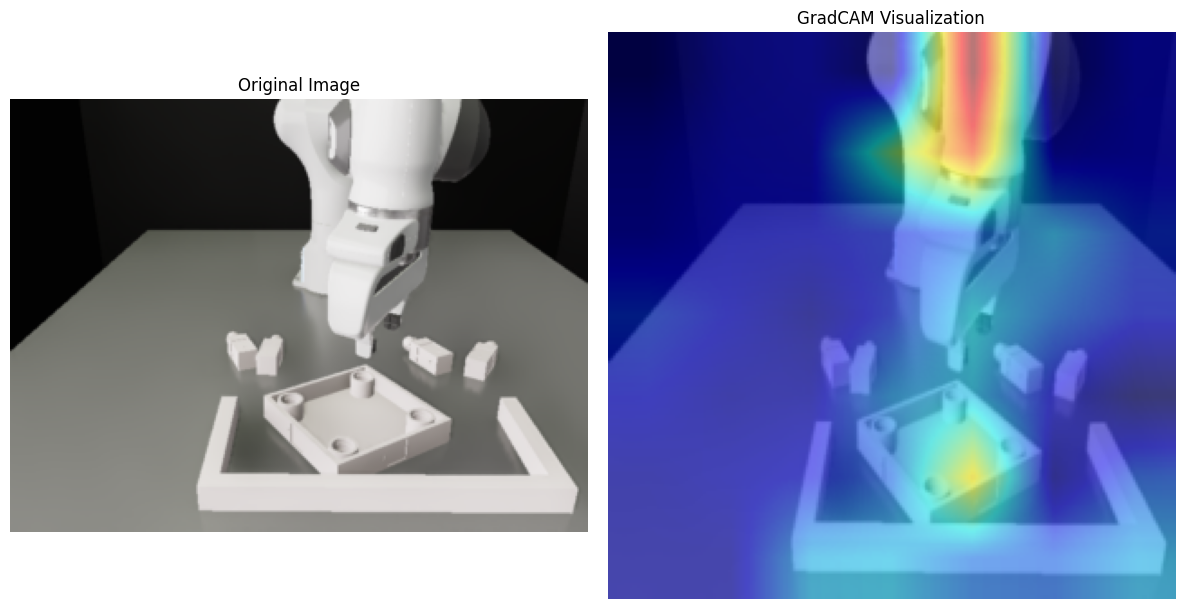

In [ ]:
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from src.models.gradcam_module import prepare_image

device = "cuda" if torch.cuda.is_available() else "cpu"

image_index = 12
raw_image = sim2["color_image2"][image_index]


model = models["MobileNetv3"]()  # change model here
# model = model.convnet # might need
model.eval()


processed_image = prepare_image(raw_image, device=device)
# processed_image = torch.from_numpy(raw_image).unsqueeze(0).permute(0,3,1,2)
# processed_image = transforms.Resize((224,224))(processed_image)
# target_layer = model.layer1[-1]
target_layer = model.blocks[-1][-1]


# print(processed_image.shape)

cam = GradCAM(model=model, target_layers=[target_layer])

grayscale_cam = cam(input_tensor=processed_image)
# print(grayscale_cam.shape)
# Resize raw_image to match GradCAM output (224, 224)

raw_image_resized = transforms.Compose([transforms.ToPILImage(), transforms.Resize((224, 224))])(
    raw_image
).convert("RGB")
# print(raw_image_resized)
# Convert raw_image_resized to numpy for overlay
raw_image_resized = np.array(raw_image_resized) / 255.0

visualization = show_cam_on_image(raw_image_resized, grayscale_cam[0, :], use_rgb=True)


# Plot original and CAM images
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax1.imshow(raw_image)
ax1.set_title("Original Image")
ax1.axis("off")

# Apply GradCAM for CNN based encoders
ax2.imshow(visualization)
ax2.set_title("GradCAM Visualization")
ax2.axis("off")

plt.tight_layout()
plt.show()

In [ ]:
model = models["CLIP"]
print(model)

config.json:   0%|          | 0.00/71.9k [00:00<?, ?B/s]

ValueError: The checkpoint you are trying to load has model type `vit-hybrid` but Transformers does not recognize this architecture. This could be because of an issue with the checkpoint, or because your version of Transformers is out of date.

**GradCAM for the Transformers**

In [9]:
model

DinoV2Encoder(
  (model): DinoVisionTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 384, kernel_size=(14, 14), stride=(14, 14))
      (norm): Identity()
    )
    (blocks): ModuleList(
      (0-11): 12 x NestedTensorBlock(
        (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
        (attn): MemEffAttention(
          (qkv): Linear(in_features=384, out_features=1152, bias=True)
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=384, out_features=384, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (ls1): LayerScale()
        (drop_path1): Identity()
        (norm2): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=384, out_features=1536, bias=True)
          (act): GELU(approximate='none')
          (fc2): Linear(in_features=1536, out_features=384, bias=True)
          (drop): Dropout(p=0.0, inplace=False)
        )
 

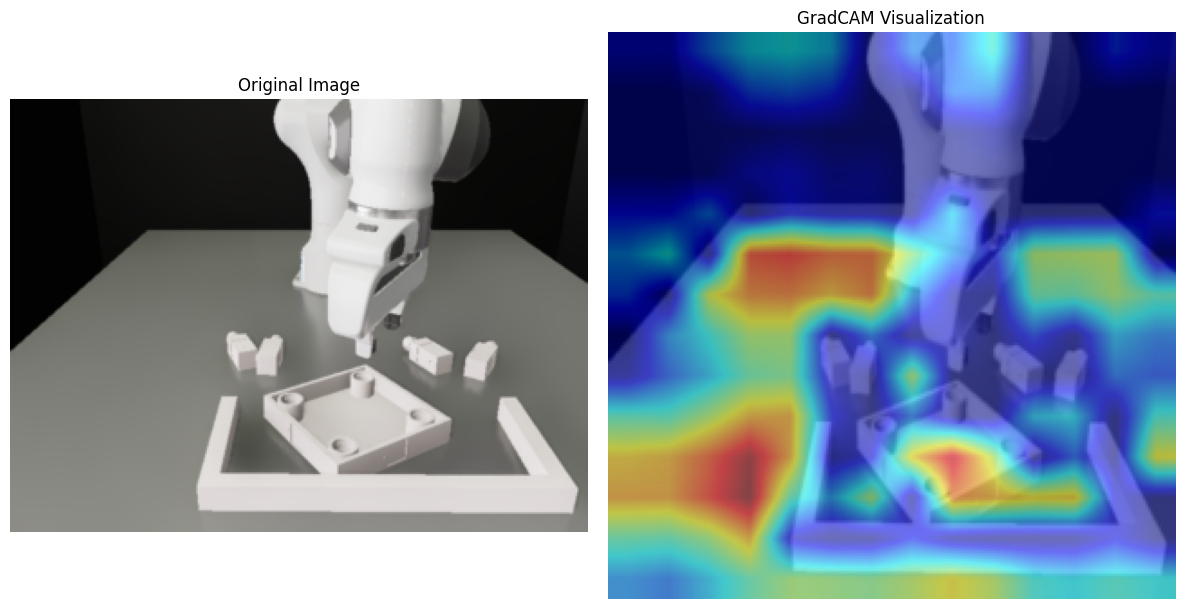

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from src.models.gradcam_module import prepare_image, reshape_transform_swin, reshape_transform_ViT

device = "cuda" if torch.cuda.is_available() else "cpu"

# Load DinoV2 model
model = models["dinov2"]()
model.eval()


# Select image
image_index = 12
raw_image = sim2["color_image2"][image_index]

processed_image = prepare_image(raw_image, device=device)

# Select target layer (last transformer block's normalization layer)
target_layers = [model.blocks[0].norm1]
# target_layers = [model.layers[-1].blocks[-1].norm1] # swin

# Create GradCAM
cam = GradCAM(model=model, target_layers=target_layers, reshape_transform=reshape_transform_ViT)

grayscale_cam = cam(input_tensor=processed_image)
grayscale_cam = grayscale_cam[0, :]

# Prepare raw image for visualization
raw_image_resized = prepare_image(raw_image, size=224).squeeze().permute(1, 2, 0).cpu().numpy()
raw_image_resized = (raw_image_resized - raw_image_resized.min()) / (
    raw_image_resized.max() - raw_image_resized.min()
)

# Create visualization
visualization = show_cam_on_image(raw_image_resized, grayscale_cam, use_rgb=True)

# Plot results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax1.imshow(raw_image)
ax1.set_title("Original Image")
ax1.axis("off")

ax2.imshow(visualization)
ax2.set_title("GradCAM Visualization")
ax2.axis("off")

plt.tight_layout()
plt.show()

In [ ]:
import timm


model_list = timm.list_models()
for model in model_list:
    print(model)

bat_resnext26ts
beit_base_patch16_224
beit_base_patch16_384
beit_large_patch16_224
beit_large_patch16_384
beit_large_patch16_512
beitv2_base_patch16_224
beitv2_large_patch16_224
botnet26t_256
botnet50ts_256
caformer_b36
caformer_m36
caformer_s18
caformer_s36
cait_m36_384
cait_m48_448
cait_s24_224
cait_s24_384
cait_s36_384
cait_xs24_384
cait_xxs24_224
cait_xxs24_384
cait_xxs36_224
cait_xxs36_384
coat_lite_medium
coat_lite_medium_384
coat_lite_mini
coat_lite_small
coat_lite_tiny
coat_mini
coat_small
coat_tiny
coatnet_0_224
coatnet_0_rw_224
coatnet_1_224
coatnet_1_rw_224
coatnet_2_224
coatnet_2_rw_224
coatnet_3_224
coatnet_3_rw_224
coatnet_4_224
coatnet_5_224
coatnet_bn_0_rw_224
coatnet_nano_cc_224
coatnet_nano_rw_224
coatnet_pico_rw_224
coatnet_rmlp_0_rw_224
coatnet_rmlp_1_rw2_224
coatnet_rmlp_1_rw_224
coatnet_rmlp_2_rw_224
coatnet_rmlp_2_rw_384
coatnet_rmlp_3_rw_224
coatnet_rmlp_nano_rw_224
coatnext_nano_rw_224
convformer_b36
convformer_m36
convformer_s18
convformer_s36
convit_base
conv

In [16]:
model = models["ResNet18"]()
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (drop_block): Identity()
      (act1): ReLU(inplace=True)
      (aa): Identity()
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act2): ReLU(inplace=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, m

**gradcam and tsne analysis of 5 furthest and closest images**

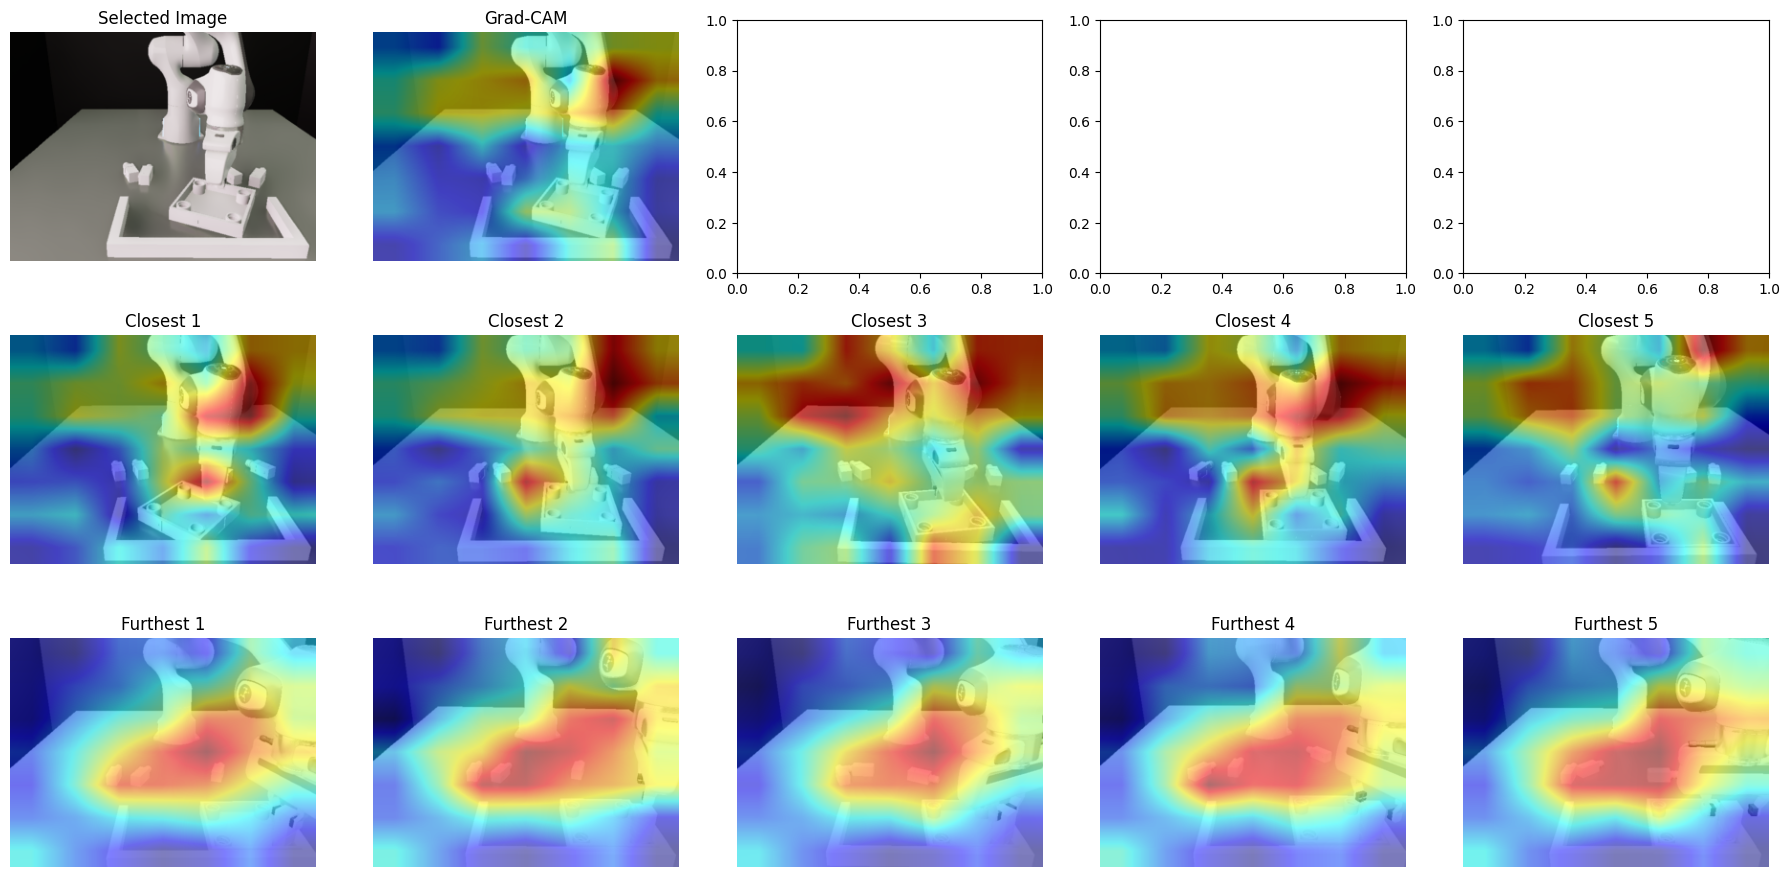

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from torchvision import models, transforms
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

# Load image
image = sim2["color_image2"][0]

model = models.resnet18()
model.eval()

# Define transformation
transform = transforms.Compose(
    [
        transforms.ToPILImage(),
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)


target_layers = [model.layer4[-1]]
cam = GradCAM(model=model, target_layers=target_layers)


def generate_gradcam(image):

    input_tensor = transform(image).unsqueeze(0)
    targets = [ClassifierOutputTarget(281)]

    # Generate the Grad-CAM heatmap
    grayscale_cam = cam(input_tensor=input_tensor, targets=targets)[0, :]

    if grayscale_cam.ndim > 2:
        grayscale_cam = grayscale_cam[0]

    original_size = (image.shape[0], image.shape[1])  # image is (H, W, C)
    heatmap_resized = cv2.resize(
        grayscale_cam, (original_size[1], original_size[0])
    )  # Resize to original size

    heatmap_resized = np.interp(
        heatmap_resized, (heatmap_resized.min(), heatmap_resized.max()), (0, 1)
    )  # Normalize to [0, 1]

    rgb_img = np.float32(image) / 255
    visualization = show_cam_on_image(rgb_img, heatmap_resized, use_rgb=True)

    return visualization


file_path = embeddings_path / "encoders/R3M18.npz"
dataset = np.load(file_path)
embeddings = dataset["embeddings"]
domain_labels = dataset["dataset_flag"]


n_samples = 5000
indices = np.random.choice(len(embeddings), n_samples, replace=False)


selected_index = 57  # choose image index
selected_embedding = embeddings[selected_index]

distances = np.linalg.norm(embeddings - selected_embedding, axis=1)


closest_indices = np.argsort(distances)[1:6]
furthest_indices = np.argsort(distances)[-5:]

# Generate Grad-CAM for the selected image and its closest and furthest images
gradcam_images = []
for index in [selected_index] + closest_indices.tolist() + furthest_indices.tolist():
    gradcam_img = generate_gradcam(sim2["color_image2"][index])
    gradcam_images.append(gradcam_img)


fig, axes = plt.subplots(3, 5, figsize=(18, 9))
axes[0, 0].imshow(np.float32(sim2["color_image2"][selected_index]) / 255)
axes[0, 0].set_title("Selected Image")
axes[0, 0].axis("off")

axes[0, 1].imshow(gradcam_images[0])
axes[0, 1].set_title("Grad-CAM")
axes[0, 1].axis("off")


for i, index in enumerate(closest_indices):
    axes[1, i].imshow(gradcam_images[i + 1])
    axes[1, i].set_title(f"Closest {i + 1}")
    axes[1, i].axis("off")


for i, index in enumerate(furthest_indices):
    axes[2, i].imshow(gradcam_images[len(closest_indices) + 1 + i])
    axes[2, i].set_title(f"Furthest {i + 1}")
    axes[2, i].axis("off")

plt.tight_layout()
plt.show()

**Action Probing**

Using device: cuda
train_embeddings - Type: <class 'torch.Tensor'>, Dtype: torch.float32, Sample: tensor([[-1.2484, -0.3758, -1.1987,  ..., -0.8190, -0.9747,  1.0441],
        [-1.3325, -0.1649, -1.8942,  ..., -0.5764, -0.3285,  1.3633],
        [-1.3392, -0.4535, -1.3111,  ..., -0.4926, -1.1440,  1.2479],
        [-1.3768, -0.8655, -1.8392,  ..., -0.1745, -0.9905,  1.0414],
        [-1.0198, -0.4324, -1.2351,  ..., -0.9377, -1.1236,  1.0374]],
       device='cuda:0')
train_labels - Type: <class 'torch.Tensor'>, Dtype: torch.float32, Sample: tensor([[ 5.2737e-01, -9.6877e-03,  1.2182e-01,  4.9723e-01,  8.6581e-01,
         -5.6027e-02,  8.6097e-01, -5.0037e-01, -9.1468e-02, -1.0000e+00],
        [ 5.2736e-01, -7.3431e-03,  1.2181e-01,  4.9741e-01,  8.6570e-01,
         -5.6155e-02,  8.6084e-01, -5.0056e-01, -9.1579e-02, -1.0000e+00],
        [ 5.2736e-01, -5.1224e-03,  1.2181e-01,  4.9747e-01,  8.6566e-01,
         -5.6259e-02,  8.6079e-01, -5.0063e-01, -9.1679e-02, -1.0000e+00],
     

Training Epochs:   1%|          | 91/10000 [00:38<1:09:21,  2.38it/s]Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7e9497edfb50>>
Traceback (most recent call last):
  File "/home/ubuntu/.local/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 
Training Epochs: 100%|██████████| 10000/10000 [1:10:28<00:00,  2.36it/s]


Average Training Loss (Last 100 Epochs): 0.3584
Plots saved to /home/ubuntu/semrep/src/models/train_val_loss_separate_smoothed.png


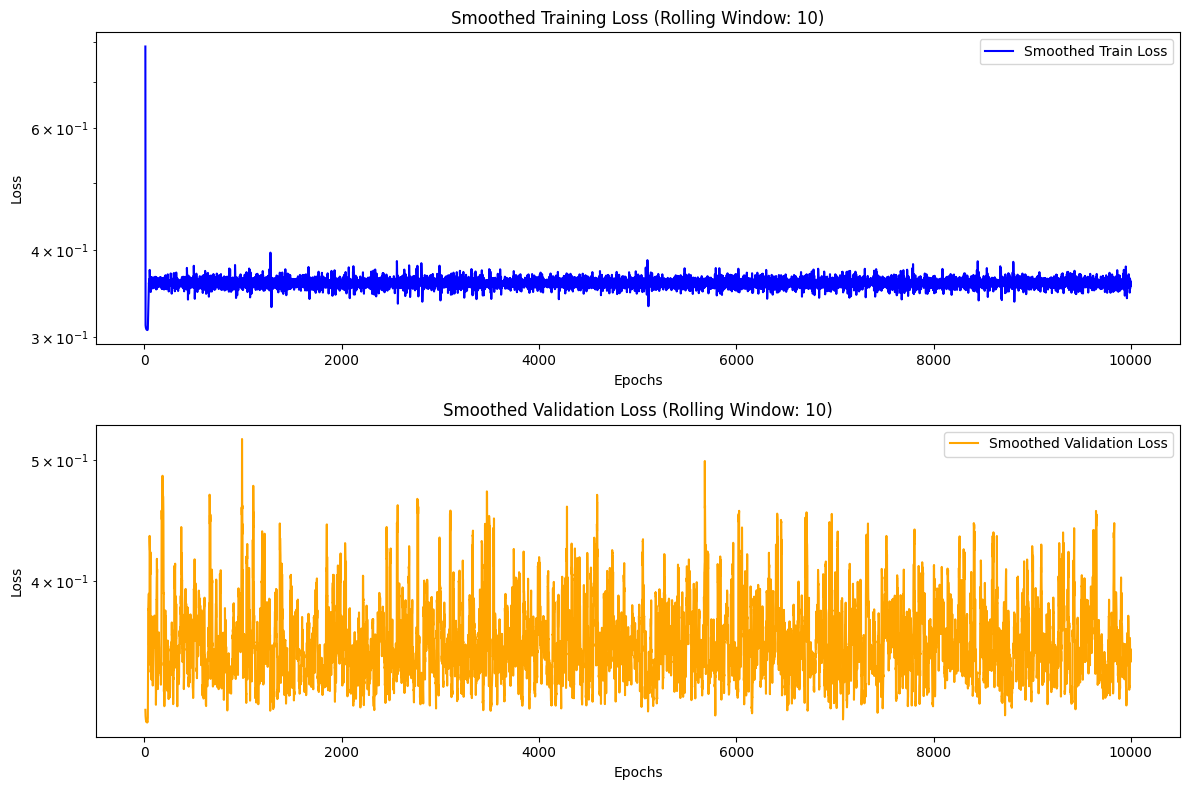

In [ ]:
from src.models.actionprobe import train_action_probe

file_path = embeddings_path / "encoders/ViT.npz"

# batch_size small = 200
# batch_size regular = 1000
# epochs 100/10000

train_action_probe(file_path, epochs=10000, batch_size=1000, lr=0.01)

**Domain Probing**


In [11]:
from src.models.domainprobe import train_domain_probe

file_path = embeddings_path / "encoders/MVP.npz"

train_domain_probe(file_path, epochs=30)

Using device: cuda
train_embeddings - Type: <class 'torch.Tensor'>, Dtype: torch.float32, Sample: tensor([[ 0.0117, -0.0445, -0.0313,  ...,  0.0417,  0.2560, -0.0163],
        [ 0.0094, -0.0437, -0.0315,  ...,  0.0370,  0.2545, -0.0163],
        [ 0.0106, -0.0434, -0.0308,  ...,  0.0383,  0.2582, -0.0142],
        [ 0.0095, -0.0438, -0.0320,  ...,  0.0397,  0.2583, -0.0112],
        [ 0.0092, -0.0427, -0.0362,  ...,  0.0405,  0.2576, -0.0179]],
       device='cuda:0')
train_labels - Type: <class 'torch.Tensor'>, Dtype: torch.float32, Sample: tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.]], device='cuda:0')
Epoch [1/30] | Train Loss: 0.6792 | Val Loss: 0.6573 | Val Accuracy: 52.02%
Epoch [2/30] | Train Loss: 0.6513 | Val Loss: 0.6304 | Val Accuracy: 58.87%
Epoch [3/30] | Train Loss: 0.6242 | Val Loss: 0.6037 | Val Accuracy: 94.63%
Epoch [4/30] | Train Loss: 0.5977 | Val Loss: 0.5782 | Val Accuracy: 99.91%
Epoch [5/30] | Train Loss: 0.5726 | Val Loss: 0.5535 | Val A

**Domain Labels Alternative**


In [ ]:
from src.models.domain_labels_r2 import domain_r_squared
from src.models.loadsplit import load_and_use_existing_split

file_path = "/home/ubuntu/semrep/embeddings/encoders/R3M18.npz"


train_data, val_data = load_and_use_existing_split(file_path)

dataset = np.load(file_path)
embeddings = dataset["embeddings"]

domain_r_squared(embeddings, dataset["dataset_flag"])

12355072
R^2 value: 0.9960977503146864


In [ ]:
from src.models.centroid_distance import centroid_distance

centroid_distance("dinov2", "euclidean", "std_dev", "zero_pad")

Sim Centroid: (384,)
Real Centroid: (384,)
Normalized Euclidean Distance: 16.740047454833984


16.740047454833984

dinov2 = 384
Normalized Euclidean Distance: 16.740047454833984
VIP = 1024
Normalized Euclidean Distance: 30.388551712036133
MVP = 768
Normalized Euclidean Distance: 30.852882385253906
R3M18 = 512
Normalized Euclidean Distance: 15.437423706054688
R3M34 = 512
Normalized Euclidean Distance: 16.640274047851562
R3M50 = 2048
Normalized Euclidean Distance: 22.048709869384766
EfficientNetB0 = 1000
Normalized Euclidean Distance: 29.71879005432129
MobileNetv3 = 1000
Normalized Euclidean Distance: 29.76523208618164


FileNotFoundError: [Errno 2] No such file or directory: '/home/ubuntu/semrep/embeddings/encoders/MCR.npz'

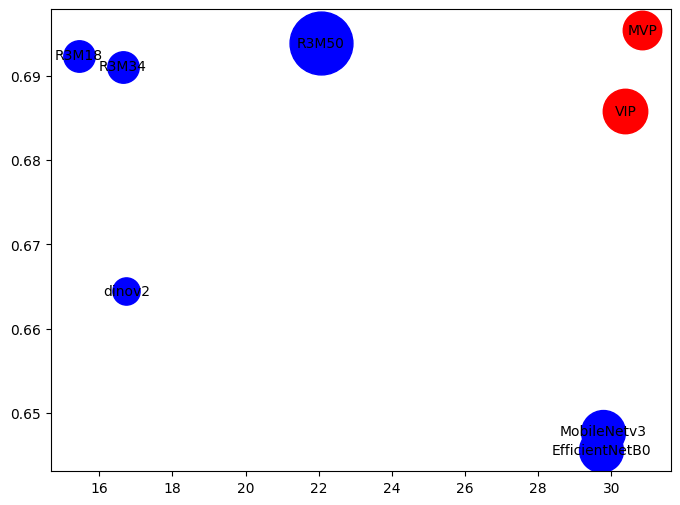

In [ ]:
from src.models.centroid_distance import centroid_distance

import re


def find_num(encoder):
    # Open the file and read its content
    with open("/home/ubuntu/semrep/src/models/averages.txt", "r") as file:
        content = file.readlines()

    # Initialize found_numbers to None
    found_numbers = None

    for line in content:
        if encoder in line:
            # Extract the number (first match)
            found_numbers = re.findall(r"\d+\.\d+", line)
            if found_numbers:
                # Return the first found number as a float
                return float(found_numbers[0])


encoders = {
    "dinov2": "Encoder",
    "VIP": "Transformer",
    "MVP": "Transformer",
    "R3M18": "Encoder",
    "R3M34": "Encoder",
    "R3M50": "Encoder",
    "EfficientNetB0": "Encoder",
    "MobileNetv3": "Encoder",
    "mcr": "Encoder",
    "ResNet18": "Encoder",
    "ResNet34": "Encoder",
    "ResNet50": "Encoder",
    "ResNet101": "Encoder",
}

# Create a larger figure
plt.figure(figsize=(8, 6))  # Adjust the size of the plot

for encoder in encoders:
    file_path = "/home/ubuntu/semrep/embeddings/encoders/" + encoder + ".npz"
    dataset = np.load(file_path)
    embeddings = dataset["embeddings"]
    x = centroid_distance(encoder, "euclidean", "std_dev", "zero_pad")
    y = 1 - find_num(encoder)
    size = embeddings.shape[1]
    if encoders[encoder] == "Encoder":
        plt.scatter(x, y, s=size, color="blue")
    elif encoders[encoder] == "Transformer":
        plt.scatter(x, y, s=size, color="red")
    plt.text(x * 1.0001, y, encoder, fontsize=10, ha="center", va="center")


# #probes
# y = np.array([1, 2, 3, 4, 5, 6]) #placeholders

# # Create a scatter plot
# plt.scatter(x, y, color='blue', label='Data Points')

# #Labels
# for i, encoder in enumerate(encoders):
#     plt.text(x[i]+0.005, y[i], encoder, fontsize=12, ha='left', va='center')

# Add titles and labels
plt.title("Domain Invariance vs Action Inference")
plt.xlabel("Centroid Distance")
plt.ylabel("Linear Probe")

# Show the plot
plt.legend()
plt.show()